In [128]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import empyrical as ep
import pyfolio as pf
from collections import OrderedDict
from IPython.display import display, HTML
%matplotlib inline

In [182]:
!git add TSMOMENTUM.ipynb
!git commit -m "double check through excel"
!git push

The file will have its original line endings in your working directory


[master bdbbc48] double check through excel
 1 file changed, 4 insertions(+), 3 deletions(-)


To https://github.com/abonaser87/StocksHistoricalData.git
   b93c369..bdbbc48  master -> master


In [159]:

def symbol_to_path(symbol, base_dir="AdjDaily"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates,col):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'TASI' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'TASI')
    dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=['Date'],date_parser=dateparse, usecols=['Date', col ], na_values=['nan'])
        df_temp = df_temp.rename(columns={col: symbol})
        df = df.join(df_temp)

        if symbol == 'TASI':  # drop dates SPY did not trad
            df = df.dropna(subset=["TASI"])

    return df

def load_df():
    dates = pd.date_range('01/01/2002', '01/01/2017')
    N= (dates[-1]-dates[0])/365
    N = str(N).split()[0]
    files = os.listdir("AdjDaily")
    symbols=[]
    for name in files:
        if name[0].isdigit():
            symbols.append(name.split('.')[0])
    df = get_data(symbols, dates, 'Close')
    df.to_pickle('database.pkl')
    return df
def normalize_data(df):
    return df/df.iloc[0,:]

def compute_daily_returns(df):
    daily_returns = (df/df.shift(1))-1
    daily_returns = daily_returns[1:]
    return daily_returns

def stats(df,period):
    if period == 'W':
        p = 52.0
    if period == 'M':
        p = 12.0
    if period == 'D':
        p = 365.0
    cagr = (df.iloc[-1]/df.iloc[0])**(1.0/(len(df)/p)) - 1.0
    dr = compute_daily_returns(df)
    sharpe = np.sqrt(p) * dr.mean() / dr.std()
    print (' CAGR(%) = ' + str(cagr * 100))
    print (' Sharpe ratio = ' + str(sharpe))

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

def pos_val(df,capital=100000,alloc=[]):
    if alloc == []:
        alloc= 1.0/len(df.columns)
    return (normalize_data(df) * alloc * capital).sum(axis=1)

# This function creates chunks and returns them
def chunkify(lst,n):
    return [ lst[i::n] for i in np.arange(n) ]

def portfolio(df,holdPeriod,capital=100000):
    if isinstance(df,pd.DataFrame):
#         capital = df.shape[1] * 1000
        alloc = 1 / df.shape[1]
    else:
#         capital = 1000
        alloc = 1 
    postions = norm(df[:holdPeriod]) * alloc * capital * 0.99845 # Trading Commissions
    if isinstance(df,pd.DataFrame):
        portfolio = postions.sum(axis=1)
    else:
        portfolio = postions
    return portfolio

def norm(df):
    if isinstance(df,pd.DataFrame):
        mask = df.iloc[0].isnull()
        df = df.loc[:,~mask]
        mask = df.iloc[0]==0
        df = df.loc[:,~mask]
    df = df / df.iloc[0]
    return df

# https://github.com/quantopian/pyfolio/blob/13af662b5c3851ede1f1910bf3c3acfca3b53c52/pyfolio/utils.py#L170
def print_table(table,
                name=None,
                float_format=None,
                formatters=None,
                header_rows=None):
    """
    Pretty print a pandas DataFrame.
    Uses HTML output if running inside Jupyter Notebook, otherwise
    formatted text output.
    Parameters
    ----------
    table : pandas.Series or pandas.DataFrame
        Table to pretty-print.
    name : str, optional
        Table name to display in upper left corner.
    float_format : function, optional
        Formatter to use for displaying table elements, passed as the
        `float_format` arg to pd.Dataframe.to_html.
        E.g. `'{0:.2%}'.format` for displaying 100 as '100.00%'.
    formatters : list or dict, optional
        Formatters to use by column, passed as the `formatters` arg to
        pd.Dataframe.to_html.
    header_rows : dict, optional
        Extra rows to display at the top of the table.
    """

    if isinstance(table, pd.Series):
        table = pd.DataFrame(table)

    if name is not None:
        table.columns.name = name

    html = table.to_html(float_format=float_format, formatters=formatters)

    if header_rows is not None:
        # Count the number of columns for the text to span
        n_cols = html.split('<thead>')[1].split('</thead>')[0].count('<th>')

        # Generate the HTML for the extra rows
        rows = ''
        for name, value in header_rows.items():
            rows += ('\n    <tr style="text-align: right;"><th>%s</th>' +
                     '<td colspan=%d>%s</td></tr>') % (name, n_cols, value)

        # Inject the new HTML
        html = html.replace('<thead>', '<thead>' + rows)
    display(HTML(html))
    
percentage_formatter = '{:.2%}'.format
float_formatter = '{:.2f}'.format

In [106]:
sb.set()
sb.set_color_codes("deep")
# Change the default figure size
# https://stackabuse.com/python-data-visualization-with-matplotlib/
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 20  
fig_size[1] = 10  
plt.rcParams["figure.figsize"] = fig_size 

In [107]:
data = pd.read_pickle('AdjustedClose.pkl')

In [108]:
df = data.xs(slice('01/01/2010','30/09/2019'),level=1,drop_level=False)
df.head()
bh = df[['AdjClose']].unstack(level=0)
bh = bh.droplevel(0,1)
df = df[['Close']].unstack(level=0)
# returns = df.resample('BM').mean()
df = df.droplevel(0,1)
# returns = returns.droplevel(0,1)
# df = df.dropna(subset=["TASI"])
# tasi = df['TASI'].copy()
# df = df.drop('TASI',axis=1)         

In [175]:
lookback = 90
mom = (df - df.shift(lookback))*0.5
mom = mom[lookback:]
mask = mom.iloc[0].isnull()
mom = mom.loc[:,~mask]

In [8]:
porto = hold.sort_values(by=hold.index.values[0], ascending=False, axis=1)
porto.head()

Symbol,2360,2010,3030,2290,2020,4190,2040,4001,2240,8010,...,8100,8080,4160,4140,6050,2370,8040,8110,8220,2110
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-08,9.200,8.625,5.700,5.35,3.9,3.845,2.970,2.650,2.35,2.32,...,-5.120,-5.20,-7.40,-7.780,-7.945,-8.335,-9.35,-9.490,-12.750,-22.320
2010-05-09,9.800,9.375,5.975,5.90,4.1,4.125,3.830,2.925,2.70,2.48,...,-4.790,-4.95,-6.95,-6.565,-5.425,-7.845,-8.95,-9.320,-12.200,-20.440
2010-05-10,10.500,9.000,6.375,6.45,4.5,4.685,3.670,3.250,3.80,3.52,...,-3.675,-4.50,-6.80,-5.355,-5.430,-7.320,-8.65,-7.820,-9.575,-18.725
2010-05-11,9.600,8.125,6.275,5.75,4.2,4.875,3.520,3.150,4.00,4.00,...,-3.780,-4.30,-6.70,-5.555,-5.165,-7.695,-7.70,-6.785,-7.100,-20.275
2010-05-12,9.675,8.250,6.150,5.15,3.9,4.785,3.435,2.950,4.20,3.56,...,-4.185,-3.90,-6.80,-5.455,-5.425,-7.620,-7.75,-5.995,-7.750,-18.885


In [19]:
tickers = np.array(porto.columns)
tickers

array([2360, 2010, 3030, 2290, 2020, 4190, 2040, 4001, 2240, 8010, 1120,
       2320, 2280, 6001, 7020, 1050, 2050, 2230, 8030, 1090, 2260, 4100,
       2060, 3020, 1211, 2350, 2070, 4030, 2002, 2200, 1212, 4002, 3050,
       1010, 4280, 1080, 2270, 1040, 1060, 6090, 2300, 4150, 1030, 4250,
       2250, 2140, 7040, 4240, 2310, 4200, 2150, 6080, 4040, 3040, 2190,
       4080, 4090, 1140, 2001, 5110, 2130, 4300, 1210, 4220, 8210, 4020,
       4290, 4050, 2120, 1150, 1020, 4180, 2100, 3090, 6060, 8200, 4260,
       4010, 2330, 6040, 8070, 2170, 4270, 4130, 6020, 4110, 8170, 1310,
       4070, 8060, 8190, 2080, 8180, 2220, 4230, 2210, 2090, 3060, 8280,
       1320, 8090, 6010, 8250, 2380, 7010, 3010, 8140, 4210, 6070, 8150,
       7030, 2160, 8130, 4061, 3080, 4170, 2030, 8240, 8160, 2340, 8120,
       8020, 8050, 2180, 8230, 8100, 8080, 4160, 4140, 6050, 2370, 8040,
       8110, 8220, 2110], dtype=int64)

In [20]:
for array in chunkify(tickers,10):
    print(len(array))

14
14
14
14
14
13
13
13
13
13


In [33]:
holdPeriod = 90
quartiles = df.loc[porto.index.values[0]:]
quartiles = quartiles[tickers[14:28]]
test = portfolio(quartiles,holdPeriod)

In [209]:
test = mom.resample('M').mean()

In [214]:
test.tail()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8170,8180,8190,8200,8210,8220,8230,8240,8250,8280
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-31,6.026818,0.887500,0.625455,2.375909,3.520227,3.479773,2.231591,3.585909,8.071591,3.063409,...,0.077045,-3.007273,-1.896364,-0.504091,10.759545,NaN,-9.428864,-0.186364,-0.929545,-2.309091
2019-06-30,5.472500,0.258125,0.450000,2.514286,4.359375,4.546875,1.627500,2.859375,7.172187,3.721563,...,-0.139375,-3.325938,-1.325312,-0.488438,16.553750,NaN,-4.409375,0.120000,1.257187,-4.134063
2019-07-31,5.223478,0.250870,0.236957,NaN,3.033696,3.969565,1.966522,1.047826,6.788913,4.359348,...,-0.470870,-3.122174,-1.921739,-0.001522,21.439348,NaN,-2.571739,-0.048261,1.490435,-4.000870
2019-08-31,4.334062,-0.183125,-0.483125,NaN,1.789063,1.523437,1.159375,-0.607812,4.751875,3.808750,...,-0.963437,-2.214375,-1.729688,0.794063,20.940000,NaN,0.475000,-0.103750,1.405625,-4.375625
2019-09-30,4.177143,-0.239524,-1.083810,NaN,0.779762,-0.566667,0.420238,-0.445238,3.047381,3.078571,...,-0.923333,-1.623095,-1.336905,1.016905,19.407143,NaN,3.697619,-0.082857,0.688571,-7.925238


In [211]:
buy = mom > 0
buy.apply(pd.value_counts,axis=1)

,False,True
Date,,
2011-01-31,86,49
2011-02-28,90,45
2011-03-31,107,28
2011-04-30,94,41
2011-05-31,71,64
2011-06-30,54,81
2011-07-31,63,72
2011-08-31,86,49
2011-09-30,63,72


In [212]:
buy = buy*1
pos = buy.diff()
pos = pos.combine_first(buy)

In [213]:
pos.apply(pd.value_counts,axis=1)

,-1.0,0.0,1.0
Date,,,
2011-01-31,NaN,86.0,49.0
2011-02-28,5.0,129.0,1.0
2011-03-31,17.0,118.0,NaN
2011-04-30,2.0,118.0,15.0
2011-05-31,1.0,110.0,24.0
2011-06-30,3.0,112.0,20.0
2011-07-31,12.0,120.0,3.0
2011-08-31,23.0,112.0,NaN
2011-09-30,1.0,110.0,24.0


In [220]:
hold = df[test.columns][lookback:].resample('M').mean()
mask = hold.iloc[0].isnull()
hold = hold.loc[:,~mask]
cash_val = hold * pos * -1
stk_val = hold * buy

In [216]:
stk_val

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8170,8180,8190,8200,8210,8220,8230,8240,8250,8280
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,0.000000,0.000000,14.124500,0.000000,28.104500,0.000000,0.000000,27.084000,49.230000,7.908500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-02-28,0.000000,0.000000,14.166316,0.000000,28.390526,0.000000,0.000000,25.465263,47.358421,7.785263,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-03-31,0.000000,0.000000,13.610476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-04-30,0.000000,10.271905,14.349524,0.000000,28.558095,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.282857,0.000000
2011-05-31,0.000000,10.199130,13.889130,0.000000,28.566522,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.409130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.795217,17.560870
2011-06-30,0.000000,9.653333,13.593810,0.000000,26.398571,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.308095,0.000000,20.710476,0.000000,0.000000,23.247619,25.944762,18.621429,25.184762,15.529524
2011-07-31,0.000000,9.590455,13.647727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15.672273,0.000000,19.021364,0.000000,0.000000,22.568182,0.000000,19.027273,28.547727,15.167727
2011-08-31,0.000000,0.000000,13.151667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.579444,0.000000,0.000000,0.000000,0.000000,22.213889,0.000000,0.000000,32.962778,0.000000
2011-09-30,0.000000,8.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.613158,0.000000,17.907368,10.997368,0.000000,25.105263,23.920000,18.400000,24.348947,16.122105


In [221]:
cash_val = cash_val.sum(axis=1) 
cash_val.iloc[0]=3433
cash_val = cash_val.cumsum()
mkt_val = stk_val.sum(axis=1)

In [222]:
cash_val

Date
2011-01-31    3433.000000
2011-02-28    3500.288947
2011-03-31    3994.805138
2011-04-30    3653.698947
2011-05-31    2832.215469
2011-06-30    2382.073564
2011-07-31    2653.829473
2011-08-31    3181.137251
2011-09-30    2569.401462
2011-10-31    2442.357549
2011-11-30    2574.078137
2011-12-31    2376.257185
2012-01-31    2245.244576
2012-02-29    1851.151719
2012-03-31     996.331243
2012-04-30    1296.862606
2012-05-31    1773.913515
2012-06-30    2134.747325
2012-07-31    1945.040368
2012-08-31    1405.155368
2012-09-30    1259.278225
2012-10-31    1620.362114
2012-11-30    1848.717614
2012-12-31    2115.576310
2013-01-31    2312.623583
2013-02-28    2780.941083
2013-03-31    3536.201537
2013-04-30    3330.170628
2013-05-31    2512.049200
2013-06-30    1615.553485
                 ...     
2017-04-30    3946.628312
2017-05-31    4304.039616
2017-06-30    4330.362116
2017-07-31    4008.923480
2017-08-31    3808.811575
2017-09-30    3361.026575
2017-10-31    3019.747010
2017-11

In [223]:
mkt_val

Date
2011-01-31    1567.078000
2011-02-28    1454.896842
2011-03-31     890.727619
2011-04-30    1297.060952
2011-05-31    2181.628261
2011-06-30    2613.406190
2011-07-31    2292.250000
2011-08-31    1611.354444
2011-09-30    2333.844211
2011-10-31    2613.425652
2011-11-30    2589.525882
2011-12-31    2926.319524
2012-01-31    3180.502174
2012-02-29    3851.297619
2012-03-31    5054.561905
2012-04-30    4693.400000
2012-05-31    3903.570455
2012-06-30    3180.963333
2012-07-31    3438.504783
2012-08-31    4340.132500
2012-09-30    4629.869524
2012-10-31    4016.176111
2012-11-30    3776.536500
2012-12-31    3572.295652
2013-01-31    3461.722273
2013-02-28    3061.704500
2013-03-31    2366.831364
2013-04-30    2741.936364
2013-05-31    3459.312381
2013-06-30    4375.309524
                 ...     
2017-04-30    2198.375238
2017-05-31    1800.203478
2017-06-30    1748.490625
2017-07-31    2140.116364
2017-08-31    2366.541429
2017-09-30    2844.443125
2017-10-31    3093.074783
2017-11

In [224]:
nav = mkt_val + cash_val
nav

Date
2011-01-31    5000.078000
2011-02-28    4955.185789
2011-03-31    4885.532757
2011-04-30    4950.759900
2011-05-31    5013.843730
2011-06-30    4995.479755
2011-07-31    4946.079473
2011-08-31    4792.491696
2011-09-30    4903.245672
2011-10-31    5055.783201
2011-11-30    5163.604019
2011-12-31    5302.576708
2012-01-31    5425.746750
2012-02-29    5702.449338
2012-03-31    6050.893147
2012-04-30    5990.262606
2012-05-31    5677.483970
2012-06-30    5315.710658
2012-07-31    5383.545151
2012-08-31    5745.287868
2012-09-30    5889.147749
2012-10-31    5636.538225
2012-11-30    5625.254114
2012-12-31    5687.871962
2013-01-31    5774.345855
2013-02-28    5842.645583
2013-03-31    5903.032901
2013-04-30    6072.106992
2013-05-31    5971.361580
2013-06-30    5990.863009
                 ...     
2017-04-30    6145.003550
2017-05-31    6104.243094
2017-06-30    6078.852741
2017-07-31    6149.039843
2017-08-31    6175.353004
2017-09-30    6205.469700
2017-10-31    6112.821792
2017-11

In [225]:
ep.aggregate_returns(compute_daily_returns(nav),'yearly') 

2011    0.060499
2012    0.072662
2013    0.082192
2014    0.026698
2015   -0.017543
2016   -0.011512
2017   -0.018921
2018    0.021771
2019    0.001802
dtype: float64

In [226]:
pf.show_perf_stats(compute_daily_returns(nav))

Start date,2011-02-28
End date,2019-09-30
Total months,4
,Backtest
Annual return,66.0%
Cumulative returns,23.3%
Annual volatility,38.9%
Sharpe ratio,1.50
Calmar ratio,3.02
Stability,0.24
Max drawdown,-21.9%


In [280]:
lookback = 21*6
mom = (df - df.shift(lookback))*0.5
mom = mom[lookback:]
mask = mom.iloc[0].isnull()
mom = mom.loc[:,~mask]

In [281]:
from collections import defaultdict
holdPeriod = 21
returns = mom[500:]
epochs = int((np.floor(returns.shape[0])/(holdPeriod)))
print(epochs)
newCapital = 100000
deciles = defaultdict(dict)
for i in range(0,epochs):
    # First loop 
    if i == 0:
        mask = returns.iloc[0].isnull()
        hold = returns.loc[:,~mask]
        hold = hold[:holdPeriod]
        h = holdPeriod
    else:
        h = (holdPeriod * i)
        hold = returns[h:holdPeriod*(i+1)]
        mask = hold.iloc[0].isnull()
        hold = hold.loc[:,~mask]  
    m = hold.iloc[0] > 1
    tickers = hold.loc[:,m].columns[:10]
    print(len(tickers))
    prices = df[df.index.get_loc(hold.index.values[0]):]
    
    if i == 0:
    # If first loop use 100k as starting capital, else use the capital from last trade
        newCapital = 100000.0
    else:
        if len(deciles) != 0:
            newCapital = list(deciles.values())[-1]
#             print(deciles)
        else:
            pass
    print(newCapital)
    if len(tickers) != 0:
        print('Hold Stocks')
        prices = prices[tickers]
    #     print(np.array(prices.columns))
        port = portfolio(prices,holdPeriod,newCapital)
#         if i == 8:
#             norm(prices[:holdPeriod]).to_excel("prices epoch "+str(i)+".xlsx")
#             port.to_excel("port.xlsx")
        for index, row in port.iteritems():
            deciles.update({index:row})                
    else:
        print('Go Cash')
        prices = prices[:holdPeriod]
        port = pd.Series(index=prices.index,data=[newCapital]*len(prices.index))
        for index, row in port.iteritems():
            deciles.update({index:row})     
print(newCapital)
print(list(deciles.values())[-1])
final = pd.Series(deciles)
fdr = compute_daily_returns(final)

85
10
100000.0
Hold Stocks
10
102681.50360728204
Hold Stocks
10
107017.3911649717
Hold Stocks
10
103840.55059346587
Hold Stocks
10
103068.7655262253
Hold Stocks
10
104085.22727774922
Hold Stocks
10
107590.46640017259
Hold Stocks
10
106926.72326249516
Hold Stocks
10
103127.39682955483
Hold Stocks
10
102809.55285658318
Hold Stocks
10
108031.13660314168
Hold Stocks
10
106075.36002903216
Hold Stocks
10
107799.38618203904
Hold Stocks
10
112005.70326794701
Hold Stocks
10
108498.62902920798
Hold Stocks
10
114477.00203186924
Hold Stocks
10
114804.77306658021
Hold Stocks
10
117113.1972758623
Hold Stocks
10
121387.19855754614
Hold Stocks
10
129285.19869320183
Hold Stocks
10
134161.2215969242
Hold Stocks
10
134779.4708769516
Hold Stocks
10
136013.64734045824
Hold Stocks
10
137644.88689269515
Hold Stocks
10
136315.63485023606
Hold Stocks
10
147398.25109051616
Hold Stocks
10
159474.28515238248
Hold Stocks
10
140002.8996484597
Hold Stocks
10
136859.68772593906
Hold Stocks
4
107893.104490168
Hold Sto

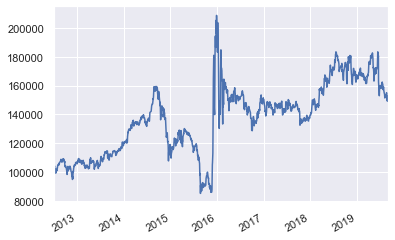

In [282]:
final.plot()

Start date,2012-07-01
End date,2019-09-03
Total months,84
,Backtest
Annual return,5.8%
Cumulative returns,49.2%
Annual volatility,26.6%
Sharpe ratio,0.34
Calmar ratio,0.12
Stability,0.61
Max drawdown,-46.6%


C:\Users\aalot\Miniconda2\envs\udacity\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.61,2014-09-10,2015-08-24,2015-12-03,322
1,38.38,2015-12-28,2016-10-02,NaT,NaN
2,22.75,2015-12-06,2015-12-13,2015-12-16,8
3,13.21,2012-09-15,2012-11-25,2013-01-12,85
4,7.23,2013-04-16,2013-05-15,2013-07-07,59


C:\Users\aalot\Miniconda2\envs\udacity\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


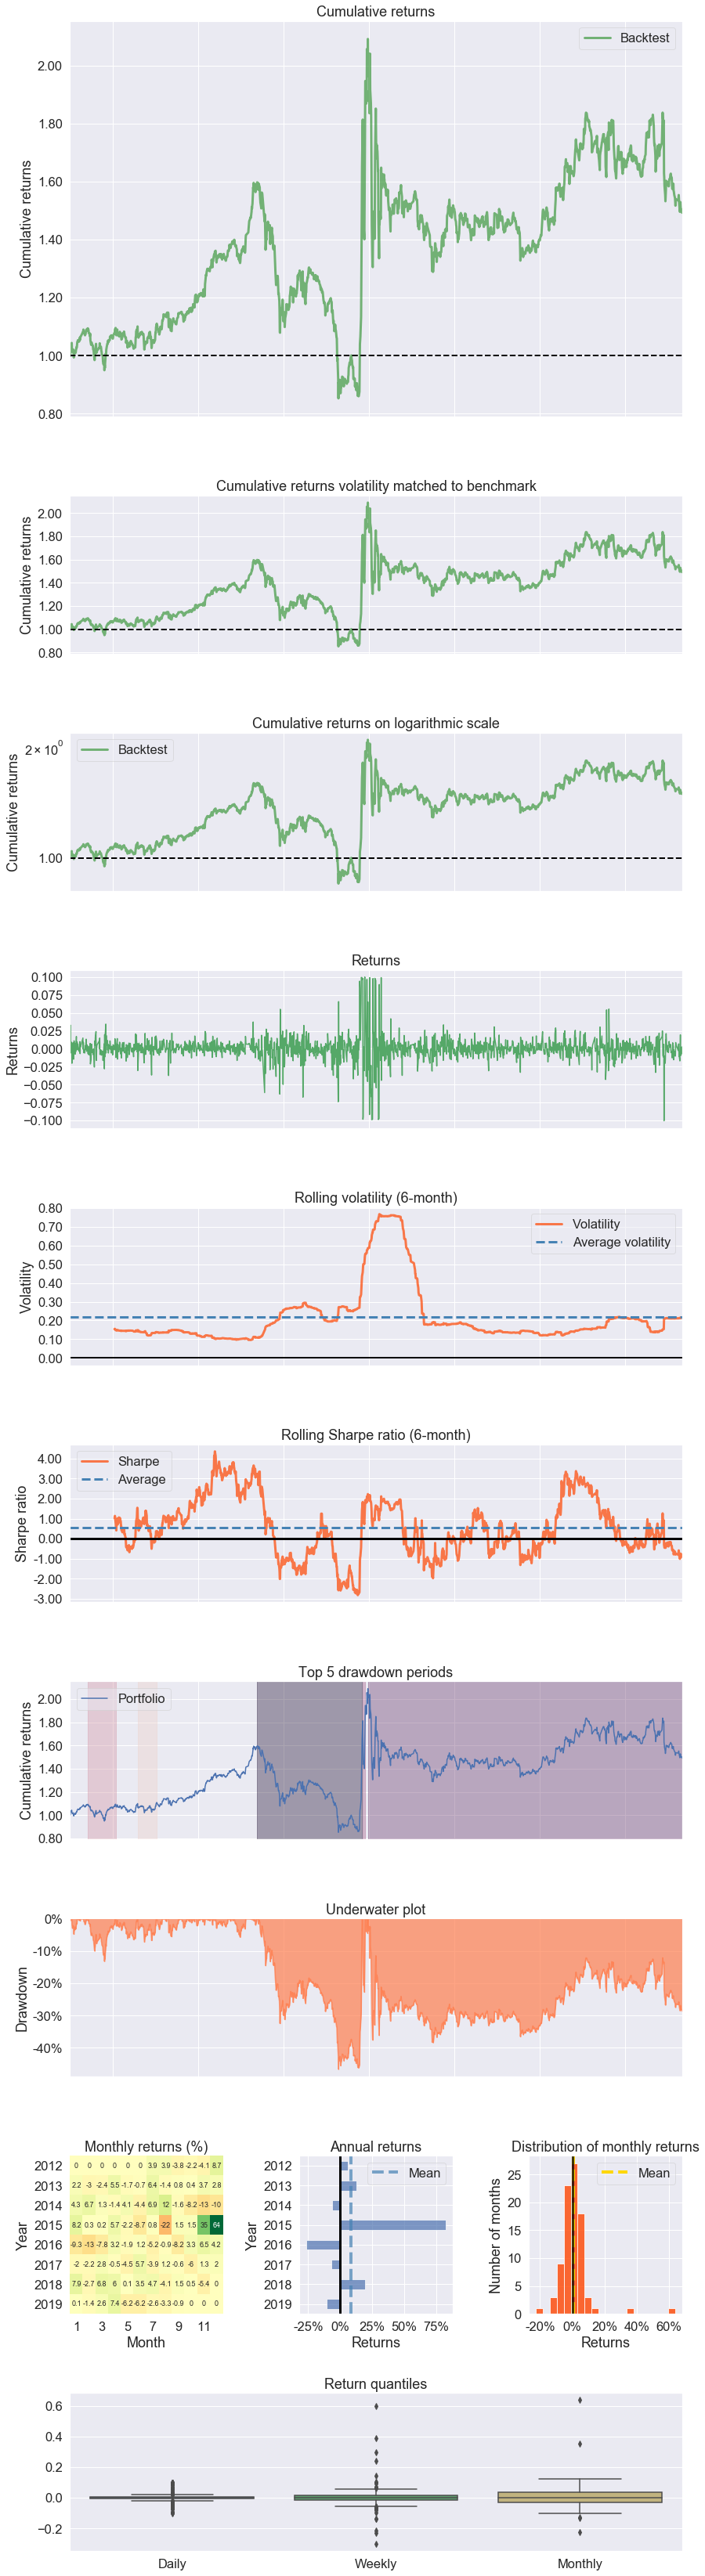

In [283]:
pf.create_returns_tear_sheet(fdr)

In [ ]:
from collections import defaultdict
def log_returns(df):
    return np.log(df[-1]/df[0])
# Working Loop for one decile
# Loop
lookbacks = [1,3,6,12]
lookbacks = [x*21 for x in lookbacks]
holdPeriods = [1,3,6,12]
holdPeriods =[x*21 for x in holdPeriods]
with pd.ExcelWriter('20200821-TSMOM.xlsx') as writer:
    for lookback in lookbacks:
        for holdPeriod in holdPeriods:
            print(lookback,holdPeriod)
            mom = (df - df.shift(lookback))*0.5
            mom = mom[lookback:]
            mask = mom.iloc[0].isnull()
            mom = mom.loc[:,~mask]
            returns = mom
            epochs = int((np.floor(returns.shape[0]-lookback+1)/(holdPeriod)))
            newCapital = 100000
            deciles = defaultdict(dict)
            for i in range(0,epochs):
                # First loop 
                if i == 0:
                    mask = returns.iloc[0].isnull()
                    hold = returns.loc[:,~mask]
                    hold = hold[:lookback]
                else:
                    x = (lookback)+(holdPeriod * i)
                    hold = returns[:x]
                    mask = hold.iloc[0].isnull()
                    hold = hold.loc[:,~mask]  
                tickers = hold.sort_values(ascending=False)
                tickers = np.array(tickers.index)
                prices = df[df.index.get_loc(hold.index.values[-1])+1:]
                prices = prices[tickers]
                chunks = chunkify(prices.T,5)    
                for j in range(0,len(chunks)):
                    name = 'Q'+str(j+1)
                    if i == 0:
                        # If first loop use 100k as starting capital, else use the capital from last trade
                        newCapital = 100000.0
                    else:
                        newCapital = list(deciles[name].values())[-1]
                    q = chunks[j].T
                    port = portfolio(q,holdPeriod,newCapital)
                    port.rename(name,inplace=True)
                    for index, row in port.iteritems():
                        deciles[name].update({index:row})                
            final = pd.DataFrame(deciles)
            fdr = compute_daily_returns(final)
            stats = pd.concat(OrderedDict([(a,perf_stats(fdr[a])) for a in fdr.columns]), axis=1)
            sheet_name = str(lookback)+','+str(holdPeriod)
            stats.to_excel(writer,sheet_name=sheet_name)